In [1]:
%run runaway_functionsv2
# %matplotlib qt


In [2]:
display(cluster_list)


Cluster,RA_ICRS,DE_ICRS,r50,Diameter,r50_table2,N,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,RV,e_RV,NRV,Dist,e_Dist,logage,e_logage,__Fe_H_,e__Fe_H_,Av,e_Av,FileName,SimbadName,_RA.icrs,_DE.icrs
,deg,deg,deg,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,,pc,pc,log(yr),log(yr),,,mag,mag,,,deg,deg
str16,float64,float64,float32,float64,float64,int16,float32,float32,float32,float32,float32,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,str30,str31,float64,float64
ASCC_107,297.1623,22.0071,0.156,20.88,0.174,59,-0.144,0.135,-5.158,0.141,1.118,0.055,--,--,--,864,30,7.440,0.121,0.353,0.103,1.372,0.129,clusters1/ASCC_107.dat,[KPR2005] 107,297.1623,22.0071
ASCC_114,324.9790,53.9990,0.180,25.92,0.216,149,-3.754,0.210,-3.435,0.145,1.063,0.039,--,--,--,911,12,7.632,0.271,0.035,0.078,1.216,0.091,clusters1/ASCC_114.dat,[KPR2005] 114,324.9790,53.9990
ASCC_127,347.1807,64.9151,0.541,75.24,0.627,113,7.490,0.261,-1.781,0.319,2.618,0.080,-11.267,2.676,16,365,10,7.496,0.131,0.152,0.115,0.668,0.080,clusters1/ASCC_127.dat,[KPR2005] 127,347.1806,64.9151
ASCC_13,78.3057,44.4212,0.564,73.08,0.609,110,-0.477,0.111,-1.737,0.108,0.899,0.076,--,--,--,1066,26,7.615,0.098,-0.075,0.078,0.915,0.027,clusters1/ASCC_13.dat,[KPR2005] 13,78.3057,44.4212
ASCC_16,81.2025,1.6256,0.367,45.12,0.376,207,1.363,0.280,0.002,0.274,2.844,0.113,21.308,1.696,12,348,3,7.088,0.061,-0.062,0.069,0.224,0.045,clusters1/ASCC_16.dat,[KPR2005] 16,81.2025,1.6256
ASCC_19,82.0035,-1.9617,0.613,72.6,0.605,173,1.112,0.263,-1.303,0.241,2.756,0.088,23.576,2.719,10,356,2,7.139,0.030,0.076,0.077,0.189,0.043,clusters1/ASCC_19.dat,[KPR2005] 19,82.0035,-1.9617
ASCC_21,82.1423,3.4771,0.419,49.2,0.41,102,1.381,0.292,-0.610,0.237,2.893,0.132,15.313,3.818,8,343,5,7.102,0.038,-0.008,0.029,0.236,0.048,clusters1/ASCC_21.dat,[KPR2005] 21,82.1423,3.4771
ASCC_32,105.7112,-26.5758,0.646,78.72,0.656,255,-3.317,0.232,3.475,0.126,1.240,0.067,34.607,4.624,10,792,11,7.432,0.022,-0.003,0.048,0.220,0.019,clusters1/ASCC_32.dat,[KPR2005] 32,105.7112,-26.5758


## Part 1: Obtain the cluster class object


In [3]:
cluster_name = 'ASCC_21'
cluster = Cluster(cluster_name)
print(cluster.name)
print(cluster.diameter)
print(cluster.N)
print(cluster.distance)
print(cluster.logage)
display(cluster.all)


ASCC_21
49.2 arcmin
102
343.0 pc
7.102


Cluster,RA_ICRS,DE_ICRS,r50,Diameter,r50_table2,N,pmRA,e_pmRA,pmDE,e_pmDE,Plx,e_Plx,RV,e_RV,NRV,Dist,e_Dist,logage,e_logage,__Fe_H_,e__Fe_H_,Av,e_Av,FileName,SimbadName,_RA.icrs,_DE.icrs
,deg,deg,deg,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,,pc,pc,log(yr),log(yr),,,mag,mag,,,deg,deg
str16,float64,float64,float32,float64,float64,int16,float32,float32,float32,float32,float32,float32,float64,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,str30,str31,float64,float64
ASCC_21,82.1423,3.4771,0.419,49.2,0.41,102,1.381,0.292,-0.610,0.237,2.893,0.132,15.313,3.818,8,343,5,7.102,0.038,-0.008,0.029,0.236,0.048,clusters1/ASCC_21.dat,[KPR2005] 21,82.1423,3.4771


## Part 2: Search stars in a region around the cluster


In [4]:
cluster.calculate_search_arcmin()

<Quantity 124.771 arcmin>

fits image exists in ASCC_21 folder
Plotting a 10 pc region around cluster.


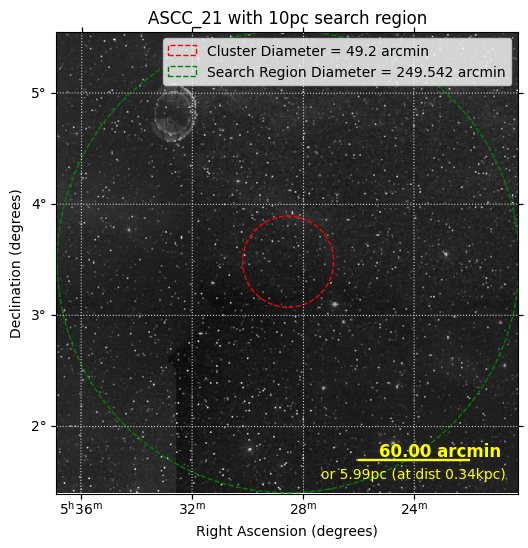

In [5]:
cluster.plot_search_region()